# Ensemble Methods

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)

dataDir = './data/'
# load original train/test data
#file_train = open(dataDir + 'train.dump', 'rb')
#file_test = open(dataDir + 'test.dump', 'rb')

#df_train = pickle.load(file_train)
#df_test = pickle.load(file_test)

file_train_wo = open(dataDir + 'train_without_noise.dump', 'rb')
df_train_wo = pickle.load(file_train_wo)
df_train = df_train_wo

file_test = open(dataDir + 'test.dump', 'rb')
df_test = pickle.load(file_test)

In [3]:
miss_cnt = df_train.apply(lambda x: sum(pd.isnull(x)))
col_dropped = miss_cnt[miss_cnt>0].index
len(col_dropped)

52

In [4]:
df_train_cont = df_train.select_dtypes(exclude=['object']).drop(list(col_dropped)+['id'], axis=1)
df_train_cat = df_train.select_dtypes(include=['object']).drop('timestamp', axis=1)

In [5]:
df_train_vec = pd.get_dummies(df_train_cat, drop_first=True)
df_tr = pd.concat([df_train_cont, df_train_vec], axis=1)
df_tr.columns, df_tr.shape

(Index(['full_sq', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part',
        'children_preschool', 'children_school',
        'school_education_centers_raion',
        'school_education_centers_top_20_raion', 'healthcare_centers_raion',
        ...
        'big_market_raion_yes', 'nuclear_reactor_raion_yes',
        'detention_facility_raion_yes', 'water_1line_yes',
        'big_road1_1line_yes', 'railroad_1line_yes', 'ecology_good',
        'ecology_no data', 'ecology_poor', 'ecology_satisfactory'],
       dtype='object', length=385), (28895, 385))

In [6]:
X = df_tr.drop('price_doc', axis=1)
y = df_tr.price_doc

In [26]:
#df_test_dropped = df_test.drop(col_dropped, axis=1)
#print(df_test.columns)
df_test.fillna(method='backfill', inplace=True)

df_test_cont = df_test.select_dtypes(exclude=['object']).drop(list(col_dropped)+['id'], axis=1)
df_test_cat = df_test.select_dtypes(include=['object']).drop('timestamp', axis=1)

df_test_vec = pd.get_dummies(df_test_cat, drop_first=True)
df_te = pd.concat([df_test_cont, df_test_vec], axis=1)
df_te.columns, df_te.shape

(Index(['full_sq', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part',
        'children_preschool', 'children_school',
        'school_education_centers_raion',
        'school_education_centers_top_20_raion', 'healthcare_centers_raion',
        ...
        'big_market_raion_yes', 'nuclear_reactor_raion_yes',
        'detention_facility_raion_yes', 'water_1line_yes',
        'big_road1_1line_yes', 'railroad_1line_yes', 'ecology_good',
        'ecology_no data', 'ecology_poor', 'ecology_satisfactory'],
       dtype='object', length=383), (7662, 383))

In [23]:
set(df_te.columns).symmetric_difference(set(df_tr.columns))

{'price_doc', 'sub_area_Poselenie Klenovskoe'}

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [9]:
from sklearn.metrics import mean_squared_error
import numpy as np

def RMSLE(y_true, y_predict):
    return np.sqrt(mean_squared_error(np.log(y_true+1), np.log(np.maximum(y_predict, 0)+1)))

In [11]:
def plot_errors(paras, error_train, error_test, para_name='parameter'):
    ax = plt.gca()
    plt.plot(paras, error_train, label='train error')
    plt.plot(paras, error_test, label='test error')
    ax.set_xscale('log')
    plt.xlabel(para_name)
    #plt.title('standardized training data')
    plt.legend()

In [14]:
from sklearn.ensemble import RandomForestRegressor

ns = [10, 50, 100]
errors_train = []
errors_test = []

for n in ns:
    rfr = RandomForestRegressor(n_estimators=n, oob_score=True)
    rfr.fit(X_train, y_train)
    errors_train.append(RMSLE(y_train, rfr.predict(X_train)))
    errors_test.append(RMSLE(y_test, rfr.predict(X_test)))

/home/matthew/anaconda3/envs/sml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.28911263420285843, 0.28222372878924173, 0.28208018462603546] [0.49620305690601096, 0.48610502623307483, 0.48477711304637711]


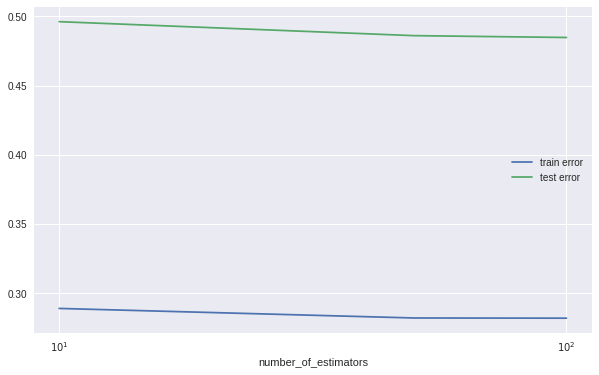

In [16]:
print(errors_train, errors_test)
plot_errors(ns, errors_train, errors_test, 'number_of_estimators')

In [28]:
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X.drop(['sub_area_Poselenie Klenovskoe'], axis=1), y)
y_pred = rfr.predict(df_te)
y_output = df_test['id']
y_output = pd.concat([y_output, pd.Series(list(np.round(y_pred, 2)), name='price_doc')], axis=1)

In [31]:
#y_output.describe()
with open(dataDir + 'test_submission_randomforest100.csv', 'w') as fw:
    y_output.to_csv(path_or_buf=fw, index=False)

In [32]:
np.any(np.isnan(df_te))

False